In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import xgboost as xgb


In [4]:
# Load your real dataset here
df = pd.read_excel("/home/prashant-malge/Desktop/externalProject/finance/data/vcc_edge_for_prediction.xlsx")


In [5]:
TIER_1_CITIES = {
    "Bengaluru", "Bangalore", "Mumbai", "Delhi", "New Delhi",
    "Hyderabad", "Chennai", "Pune", "Gurgaon", "Noida"
}

def map_city_tier(city):
    if pd.isna(city):
        return "Unknown"
    return "Tier_1" if city in TIER_1_CITIES else "Tier_2_3"

df["city_tier"] = df["city"].apply(map_city_tier)


In [6]:
df["revenue_per_employee"] = df["revenue"] / df["employeeCount"]


In [7]:
df["tenure_index"] = df["companyAge"] / df["employeeCount"]


In [8]:
y = np.log1p(df["revenue"])

X = df[
    [
        "employeeCount",
        "companyAge",
        "revenue_per_employee",
        "tenure_index",
        "companyType",
        "category",
        "city_tier",
        "state"
    ]
]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
numerical_features = [
    "employeeCount",
    "companyAge",
    "revenue_per_employee",
    "tenure_index"
]

categorical_features = [
    "companyType",
    "category",
    "city_tier",
    "state"
]


In [11]:
numeric_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])


In [10]:
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb_model)
])


In [11]:
param_grid = {
    "model__n_estimators": [300, 500],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [3, 4, 5],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 500, 'model__subsample': 0.8}


In [12]:
# Predict (log scale)
y_pred_log = best_model.predict(X_test)

# Back to actual revenue
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mape = mean_absolute_percentage_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("===================================")
print(f"RMSE  : ${rmse:,.2f}")
print(f"MAPE  : {mape:.2%}")
print(f"R²    : {r2:.4f}")
print("===================================")


RMSE  : $17.71
MAPE  : 30.07%
R²    : 0.8842


In [13]:
feature_names = (
    numerical_features +
    list(
        best_model.named_steps["preprocessor"]
        .transformers_[1][1]
        .named_steps["encoder"]
        .get_feature_names_out(categorical_features)
    )
)

importances = best_model.named_steps["model"].feature_importances_

feature_importance_df = (
    pd.DataFrame({"Feature": feature_names, "Importance": importances})
    .sort_values("Importance", ascending=False)
)

print(feature_importance_df.head(10))


                                  Feature  Importance
2                    revenue_per_employee    0.525884
0                           employeeCount    0.441822
3                            tenure_index    0.011584
4             companyType_Private Company    0.002986
6      category_Customer Support Services    0.002213
35                    state_Uttar Pradesh    0.001620
7   category_Data Scraping and Processing    0.001602
28                      state_Maharashtra    0.001563
1                              companyAge    0.001508
33                       state_Tamil Nadu    0.001299


In [14]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_actual, y_pred)
print(f"MAE   : ${mae:,.2f}")


MAE   : $2.09


In [15]:
from sklearn.metrics import median_absolute_error

med_ae = median_absolute_error(y_actual, y_pred)
print(f"Median AE : ${med_ae:,.2f}")


Median AE : $0.08


In [16]:
sample_company = pd.DataFrame([{
    "employeeCount": 250,
    "companyAge": 12,
    "revenue_per_employee": 1.8,   # can be estimated or historical avg
    "tenure_index": 12 / 250,
    "companyType": "Private Company",
    "category": "Managed Services",
    "city_tier": "Tier_1",
    "state": "Karnataka"
}])


In [17]:
# Predict log-revenue
predicted_log_revenue = best_model.predict(sample_company)

# Convert back to actual revenue
predicted_revenue = np.expm1(predicted_log_revenue)

print(f"Predicted Revenue: ${predicted_revenue[0]:,.2f}")


Predicted Revenue: $318.77


### SHAP Analysis

In [18]:
# Extract trained preprocessor and model
preprocessor = best_model.named_steps["preprocessor"]
xgb_model = best_model.named_steps["model"]

In [19]:
X_test_transformed = preprocessor.transform(X_test)
# Numeric feature names
num_features = [
    "employeeCount",
    "companyAge",
    "revenue_per_employee",
    "tenure_index"
]

# Categorical feature names after OneHotEncoding
cat_features = list(
    preprocessor
    .transformers_[1][1]
    .named_steps["encoder"]
    .get_feature_names_out(
        ["companyType", "category", "city_tier", "state"]
    )
)

feature_names = num_features + cat_features


In [20]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)


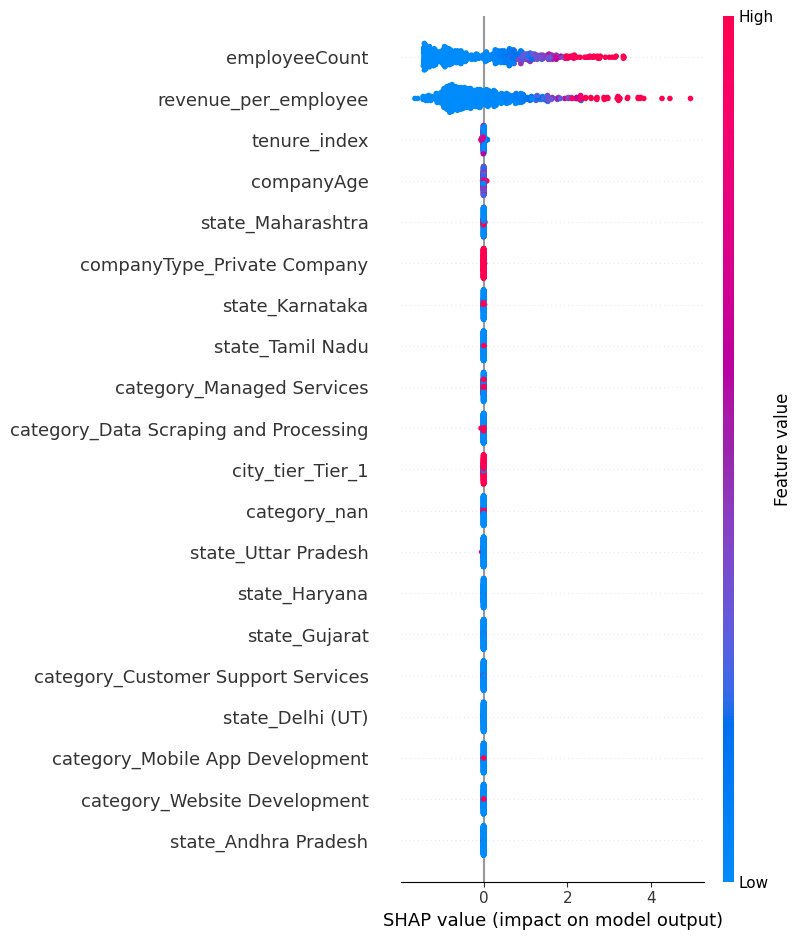

In [21]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    show=True
)


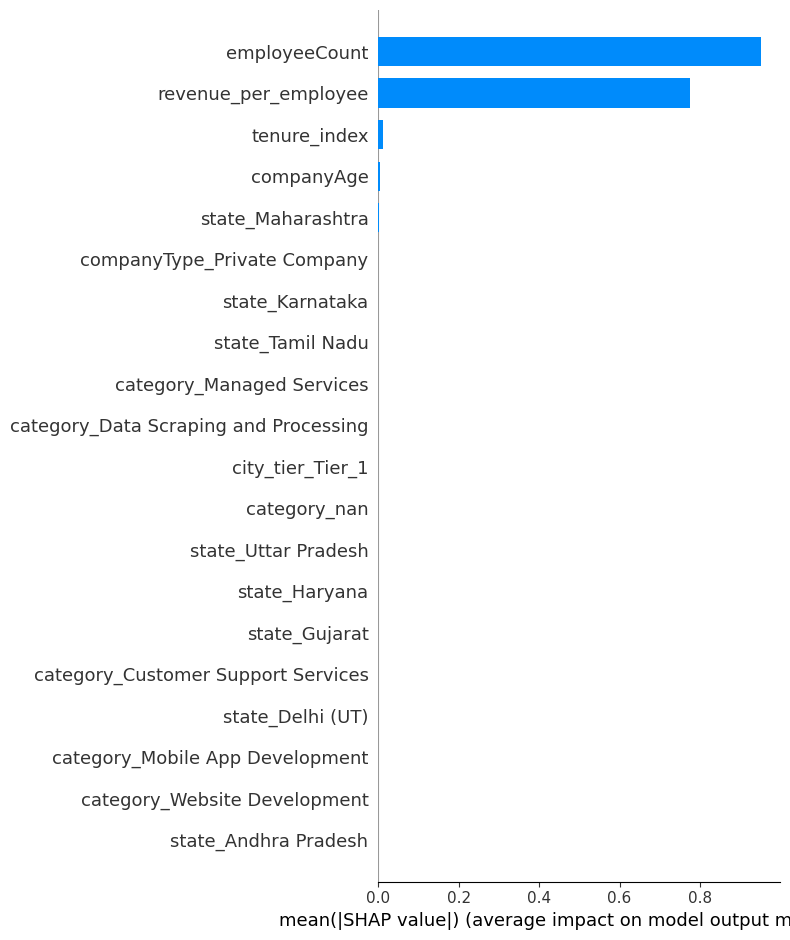

In [22]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)
